<a href="https://colab.research.google.com/github/YangJeongA/class2022Spring/blob/main/220425_audio_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Processing

https://musiclab.chromeexperiments.com/Spectrogram/

###1. Fourier transform (분석용)
- sine곡선에서 기본적으로 x축은 시간임. 시간 상의 이 신호에서 중요한 것은 주파수로 분석하는 것. 이 사이트에서 그것을 직접 볼 수 있음. 
- 사이트: Spectrogram
  - spectrum은 주어진 signal에 대해 어떤 주파수 성분이 많이 있는지를 분석하기 위한 것
  
    : 기본적으로 시간축에 파형이 있을 때, 어떤 성분이 많은지가 중요함 (낮은 음이 많은지, 높은 음이 많은지, 이것이 얼만큼 체계적으로 많은지 설명하는 것이 spectrogram.). 어떤 성분이 많은지를 입체적으로 보여주는 것이 spectrogram. -> wave 상에서는 이런 것들을 보기 힘드므로 이렇게 분석하는 것이 필요
- spectrogram은 spectrum을 time 축으로 concatenate한 것
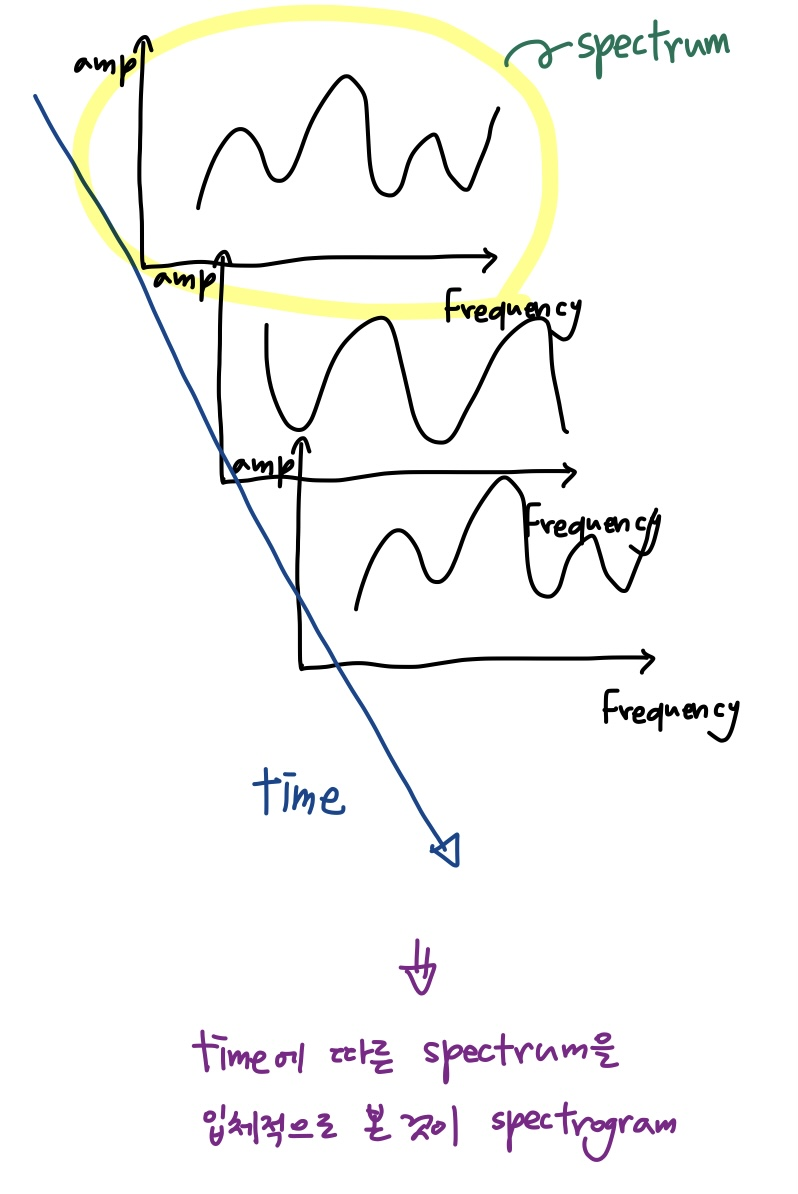
  - 한장의 spectrum을 여러장 연결해놓은 것이 spectrogram (spectrogram: concat of spectrums over time)
- given signal에 대해 분석하기 위한 것
- 방법: signal (inner product) a series of complex phasors with different frequencies
  - given signal이 있을때 여러 complex phasors가 다양한 frequency를 갖도록 해서 다양한 complex phasors를 만듦
  (given signal과 똑같은 길이의 complex phasor 만듦)
    - 그 다음, 만든 complex phasors를 given signal에 inner product함 (inner product는 일종의 correlation. 즉, 해당 frequency가 얼마나 있는지 probing하는 것)
      - 10Hz 짜리를 inner product해서 어떤 값이 나오면 10Hz짜리가 given signal에 그만큼 있다는 얘기. 값이 작을수록 10Hz짜리가 given signal에 적게 있다는 말.
    - 그 다음 결과치를 plotting. 이를 통해 우리가 준비한 값(complex phasors에 담겨 있는 frequencies)이 given signal에 얼마나 있는지 알아보는 것. plotting한 결과가 spectrum.
  - 왜 sine phasor가 아닌 complex phasor를 사용할까?

    : phase sensitivity 때문. 개념적으로는 sine phasor을 inner product하는 거라고 생각하면 되지만 sine phasor의 약점 때문에 complex phasor 사용
    

inner product
: 같은 길이의 두 벡터를 같은 위치에 있는 것끼리 곱하고 더하는 것 

-> 일종의 correlation 정보를 주는 것. inner product를 통해 given signal에 내가 만든 complex phasor 중 하나가 갖고 있는 frequency 정보가 얼마나 많이/적게 있는지에 대한 정보를 얻을 수 있는 것

-> 요약(중요): inner product의 결과값은 복소수이기 때문에 바로 사용하지 못함. 즉, magnitude를 활용하고, 이 magnitude인 (a, b)의 절대값이 abs값. 
  - 이 값을 우리는 Fourier transform 된 값으로 해서 spectrum을 쓰고, 이 spectrum을 시간축으로 concat 시키면 spectrogram!!!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display    # librosa -> sound 관련 package

## load / plot / play sound file

In [ ]:
# sound file 불러오기

import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')     # 48600개의 signal이 저장되어 있고 sr은 22050(1초에 22050개의 숫자)

In [ ]:
# 위의 코드처럼 github에서 불러와도 되고, 이렇게 직접 파일을 업로드 해도 됨

from google.colab import files
fn = files.upload()


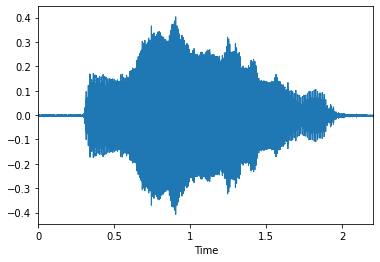

In [ ]:
librosa.display.waveplot(s, sr)
ipd.Audio(s[7000:12000], rate=sr)

# normalize 해주지 않은 경우

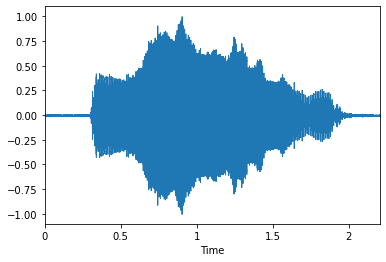

In [ ]:
s = librosa.util.normalize(s)
librosa.display.waveplot(s, sr)
ipd.Audio(s[7000:12000], rate=sr)   # sound를 들어볼 수 있게 해줌 (ipd package) -> slicing 통해서 sample 선택 가능


# librasa에서 제공하는 normalize, plotting(waveplot) 기능
# normalize -> signal을 -1~1 사이로 scale up/down 해주는 것

## Fourier Transform for Spectrogram

- 위에서 선택한 sample(s[7000:12000])으로 spectrogram을 만들어 볼 것. 선택한 sample이 given signal이 되는 것.
  - given signal에서 여러 장의 spectrum을 만듦으로써 spectrogram을 만드는 것

(0.0, 5000.0)

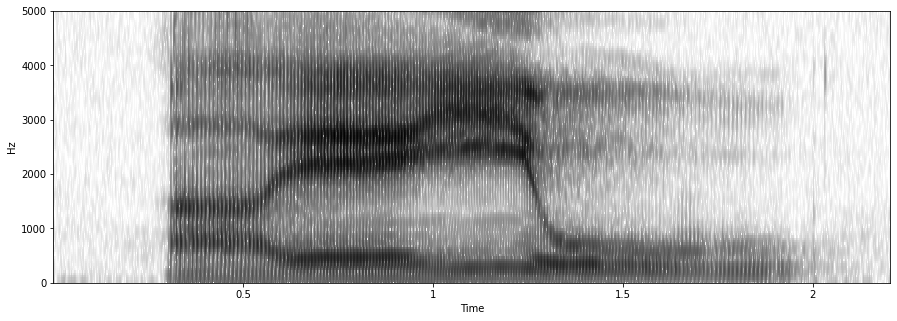

In [ ]:
s_preemp = librosa.effects.preemphasis(s)

n_fft=512                   # spectrum의 가로축을 얼마나 촘촘하게 만들 것인지. -> spectrum의 x축 끝 값은 sr. sr을 512개로 나누는 것
hop_length=int(0.001*sr)    # 현 spectrum과 다음 spectrum 사이의 간격
win_length=int(sr*0.008)    # spectrum 한 장의 가로길이

# 한 장의 spectrum이 뭔지 파악할 줄 알아야 함 

spec = librosa.stft(s_preemp, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window = 'hann')
magspec = np.abs(spec)        # np.abs()를 통해 복소수에서 실수로 바뀜
# np.abs()함수 -> inner predict를 해줄때 complex phasor이기 때문에 값이 a+bi 형태의 복소수임. 이 복소수를 점 찍어줄 수 있게 해주는 게 이 함수
# 즉, spectrum 상에 찍히는 y 값은 복소수의 원점으로부터의 거리인 (a, b) -> 절대값 사용
dBspec = librosa.amplitude_to_db(magspec, ref=np.max)   # 실수를 다시 데시벨로 scale을 바꿔줌 

plt.figure(figsize=(15, 5))
librosa.display.specshow(dBspec, sr=sr, x_coords = np.linspace(1, len(s), dBspec.shape[1])/sr , x_axis='time', y_axis='linear', cmap='Greys')
plt.ylim((0,5000))

- 위 그림이 spectrogram. 

  -> 입체적으로 봐야함. 까만 부분이 우리 쪽으로 튀어나와 있는 부분이고 흰 부분이 우리 눈에서 멀리 있는 부분이라고 생각하면 됨. 즉, 입체적으로 생각해서 우리 눈으로 다가올 수록 frequency가 높아지는 것. 멀어질수록 frequency 낮아짐. 그 입체적인 축이 
frequency 축.

  -> 즉, spectrogram은 y축이 frequency!!! (중요)

- 한 장의 spectrum

  -> 가로축(x축)이 frequency. 오른쪽으로 갈수록 frequency 높음.




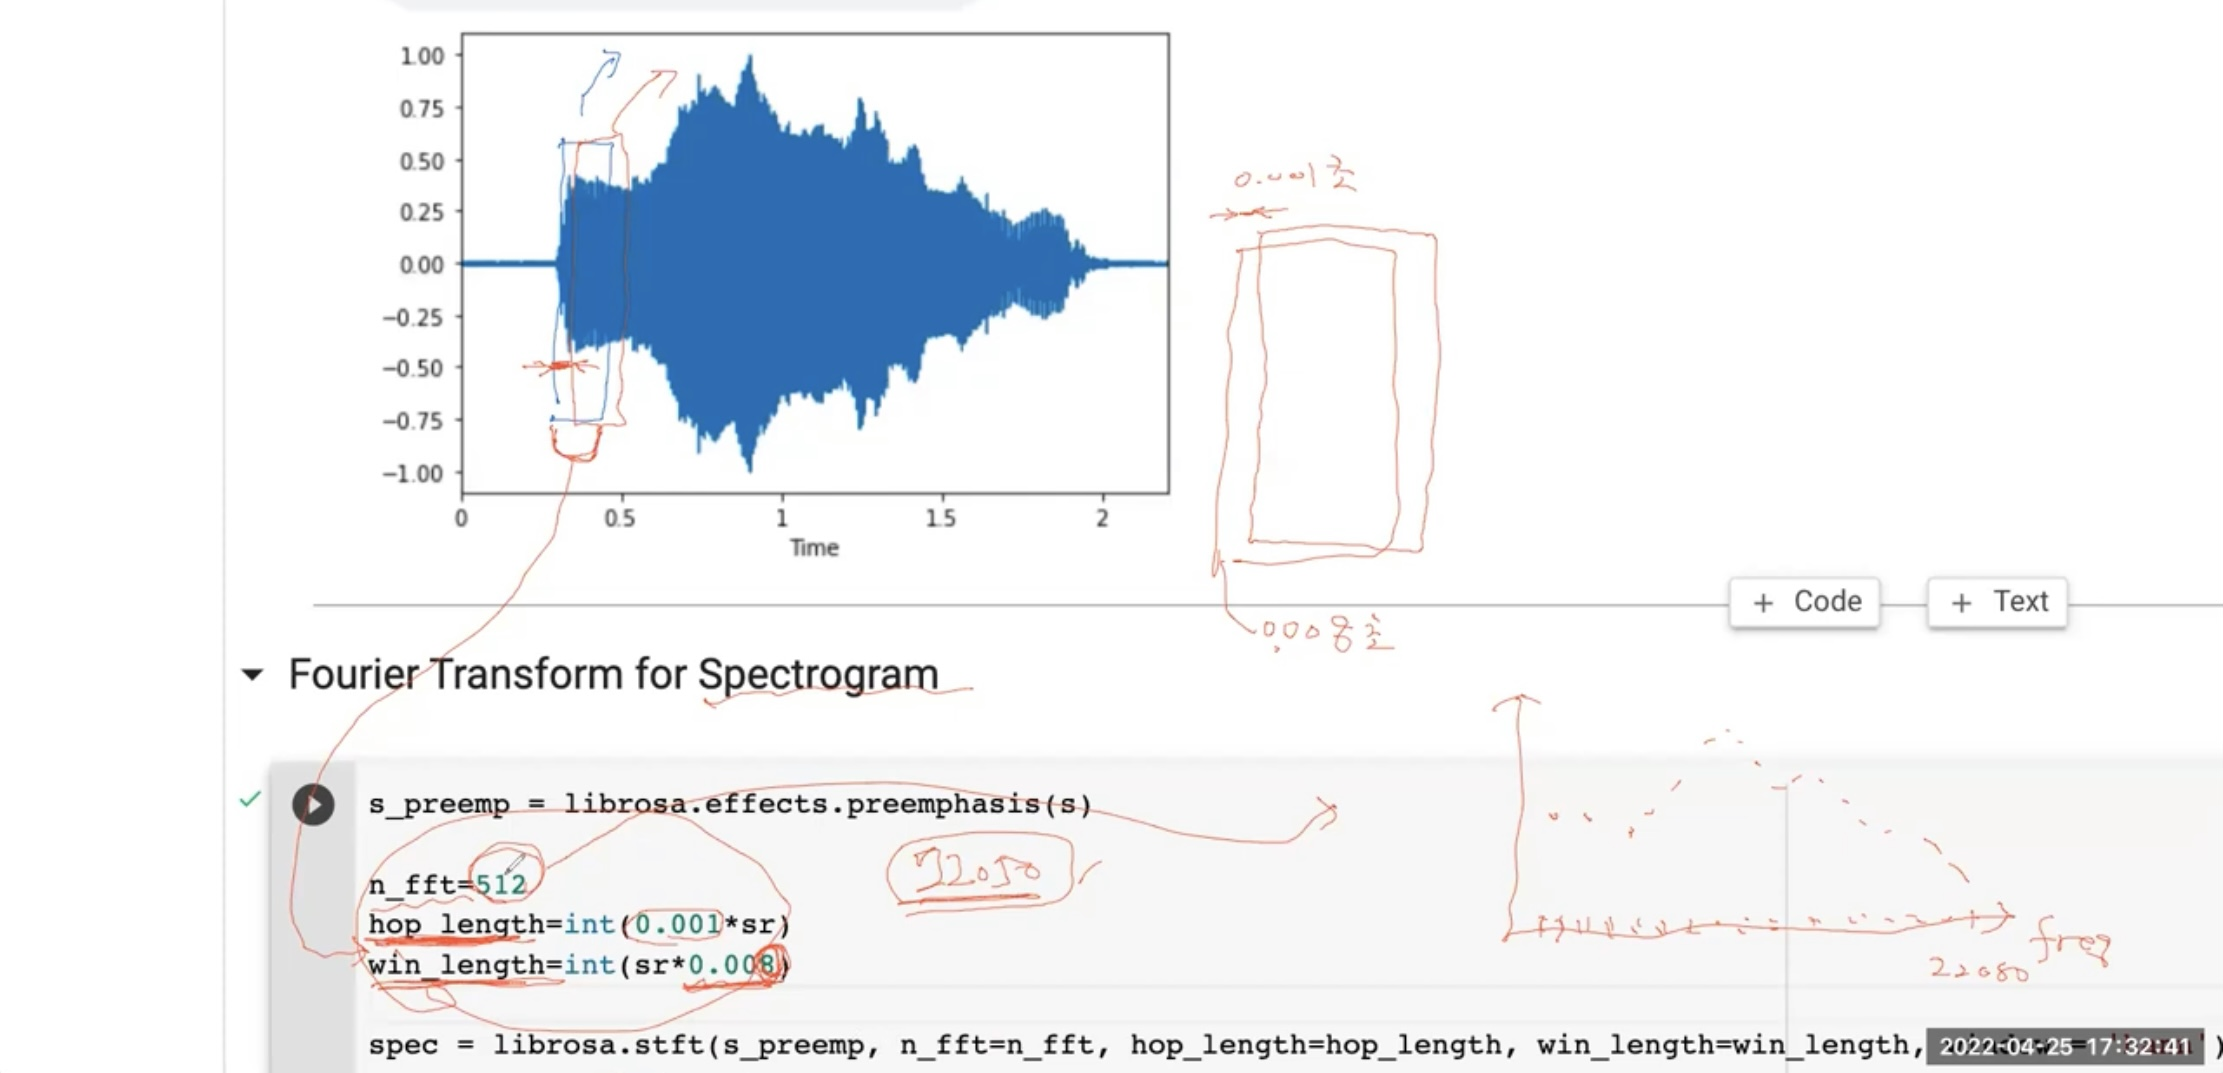

###2. Filter (변환용)

- 어떤 신호에 대해 실제로 변형을 주는 것 
- 소리에 변형을 가하고 싶을 때는 주파수별로 얘기함
- 어떤 소리가 있을 때, 저음 부분을 약하게 하고 싶다거나 강하게 하고 싶을 때. 즉, 어떤 주파수대의 크기를 조절하고 싶을 때 사용 
- A --> function --> B
- signal A --> filter --> signal B
- 신호 (time function: x축이 time)를 입력으로 하는 함수를 filter라고 함
- 왜? filter 라고 부름? 이 함수의 목적이 특정 주파수에 대한 manipulation이므로. (예: 어떤 주파수대를 작게, 크게, 통과, 제거 등)
- 방법: weighted sum of signal's shifts (두가지 방법: FIR, IIR).
  - 한 signal을 shift한 것들의 sum

  - FIR: Y(k) = b1X(k) + b2X(k-1) + ...
    - Y = H * X
      - FIR 필터에서는 b1, b2... 이 값을 알고 있어야 함
      - H가 b1, b2.. 들의 합
  - IIR: X(k) = a1Y(k) + a2Y(k-1) + ... 
    - Y = (1/H) * X
      - IIR 필터에서는 a1, a2, ... 이 값을 알고 있어야 함

- FIR, IIR 모두 b1(a1)만 1이고 b2(a2)부터는 다 값이 0이면 filtering 효과가 없음 (역할x)
- 밑에 함수랑 연관해서 이 부분 잘 알아두기!

## Filter for audio transformation

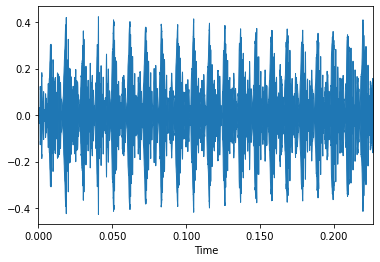

In [ ]:
from scipy.signal import lfilter
sig = s[7000:12000]              # -> given signal
sig = lfilter(np.array([1]), np.array([1]), sig, axis=0)          
# filter 해주는 function -> lfilter(b, a, signal) -> np.array()통해서 array로 바꿔서 b/a값 넣어줘야 함 -> 1 넣으면 아무 변화x
librosa.display.waveplot(sig, sr)
ipd.Audio(sig, rate=sr)

# 이처럼 filter를 통해 signal을 변형시킬 수 있음 

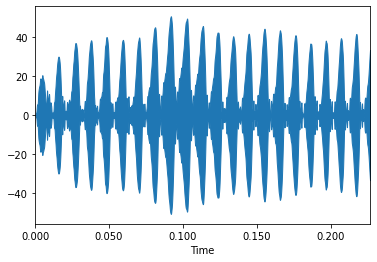

In [ ]:
from scipy.signal import lfilter
sig = s[7000:12000]              # -> given signal
sig = lfilter(np.array([1/2, 1/2, 1/2, 1/2]), np.array([-1/2, 1/2]), sig, axis=0)        
# FIR을 1/2 해주면 소리가 좀 부드러워짐  
librosa.display.waveplot(sig, sr)
ipd.Audio(sig, rate=sr)

# Auto correlation
- measuring pitch / F0
- given signal과 inner product 하는 또 다른 signal이 있을 때
  - 또 다른 signal(내가 만든 signal)을 조금씩 옆으로 옮기다 보면, given signal과 corrleation이 높아지는 순간(given signal과 유사도 아주 높음)이 있음
  - corrleation이 y축이고, lag(내가 만든 signal을 조금씩 옆으로 옮기는 정도). 
    - 안 움직였을 때 (given signal과 완전히 동일한 위치일 때) corrleation 가장 높았다가, 움직일 수록 조금씩 corrleation 낮아졌다가 어느 순간 다시 corrleation 높아짐.
    - 이때, 처음 나타나는 corrleation peak (signal을 움직이기 시작하고 제일 처음 corrleation이 가장 높게 나오는 지점)가 중요. 이 부분이 pitch가 됨!
      - 맨 처음 나오는 corrleation peak까지의 lag의 시간과 given signal의 pattern이 다시 반복될 때 까지의 시간이 동일함.
      - 따라서, 1/first lag의 peak값이 pitch값 -> 이것이 Auto corrleation -> 자기 자신(auto)으로 시간 lag을 만들어서 corrleation 파악을 하므로 auto corrleation. 이런식으로 알고리즘을 이해하면 됨

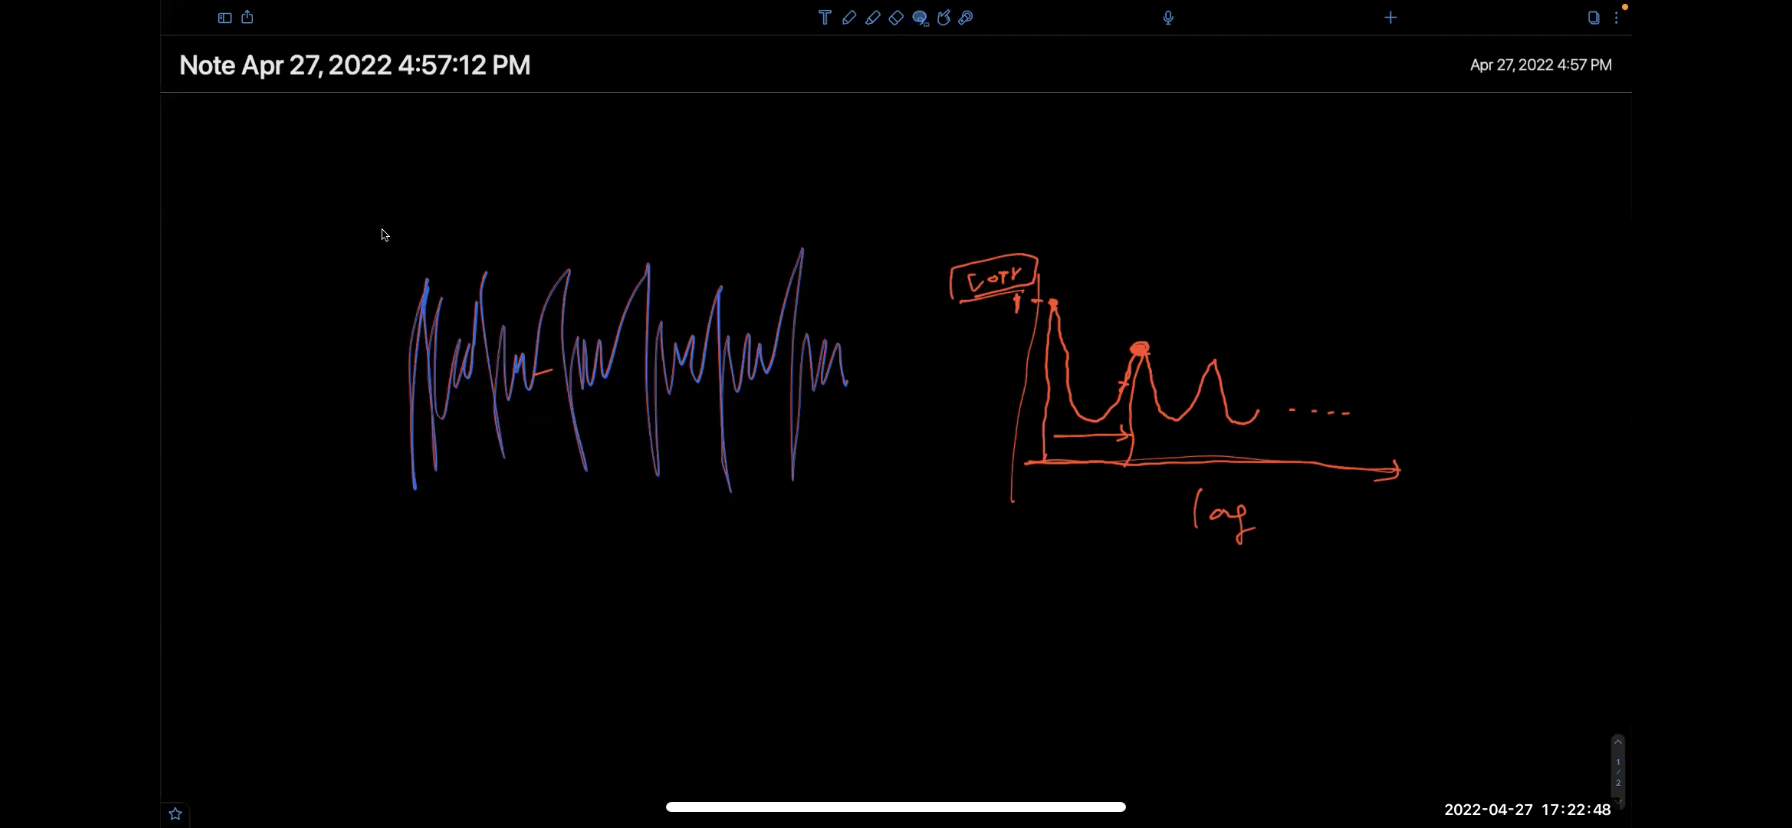

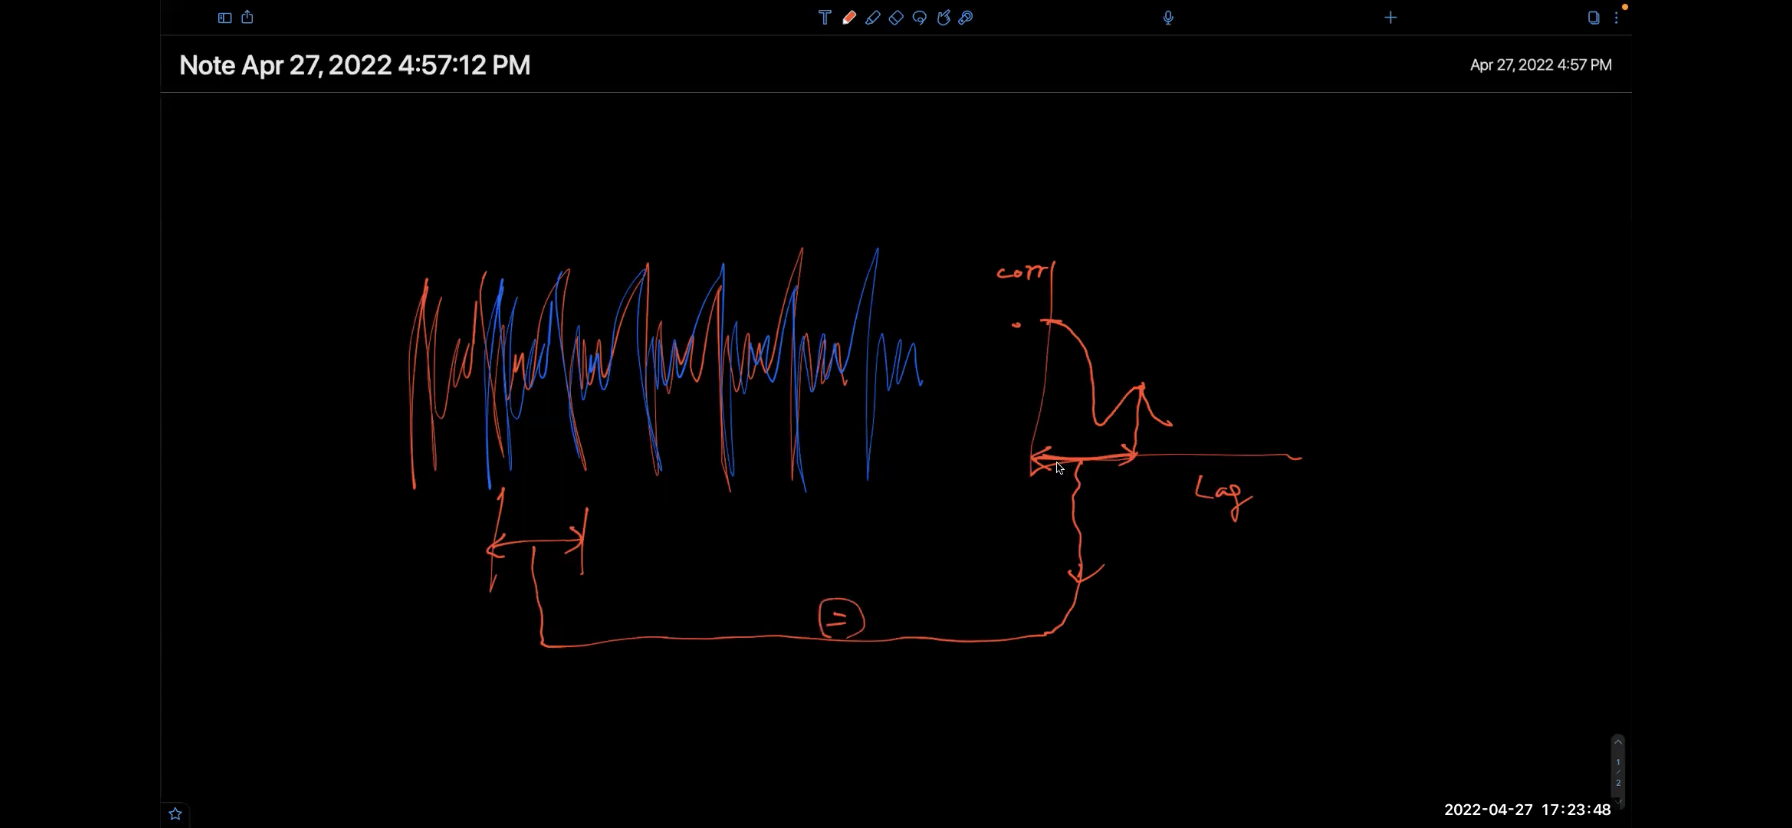

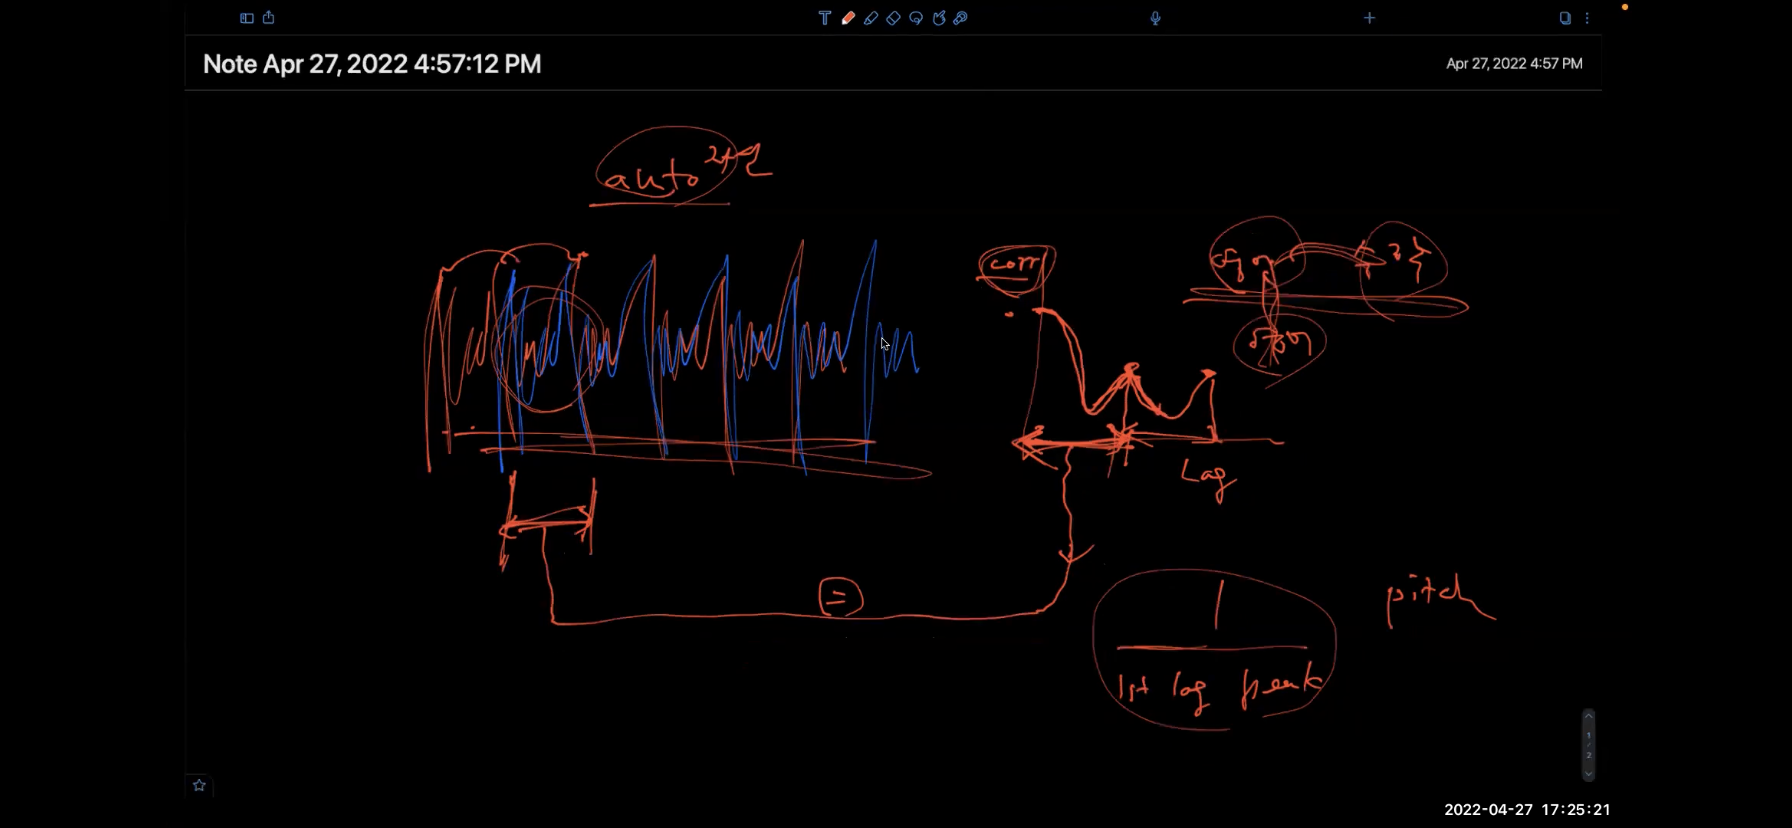


## Autocorrelation for pitch(F0) measurement

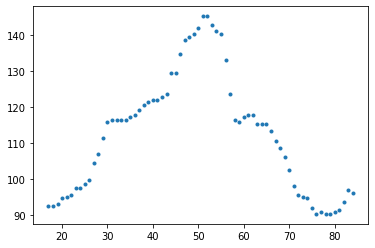

In [ ]:
F0, voiced_flag, voiced_prob = librosa.pyin(s, 60, 200)
plt.plot(F0, '.')

# 소리의 pitch를 plotting 해줌

# RMS: root mean square
- measuring intensity / F0
- square -> mean -> root
  1. 모든 값을 제곱 시킴
  
    : signal이 있고, 0점이 있을 때 signal은 0점보다 높은 것도 있고 낮은 것도 있음. 이 값들을 다 제곱을 시키면 음수인 값들도 다 0점 위로 올라가게 됨. 
    - 마이너스이든 플러스이든 구분을 하지 않기 위해 제곱을 하는 것
  2. 제곱한 값을 다 더한 뒤에 mean을 구함
  3. mean에 root를 씌움 (1에서 제곱을 했기 때문에 원래대로 되돌리기 위해)

- root mean square를 통해 서로 다른 signal의 진폭을 비교할 수 있음. 진폭이 큰 signal일수록 RMS의 값이 크기 때문. (이를 비교하기 위해서는 절대적인 크기의 비교가 필요하므로 제곱을 하는 것!).
  - 따라서 RMS는 intensity(데시벨)을 재는 것

## RMS(Root Mean Square) for intensity

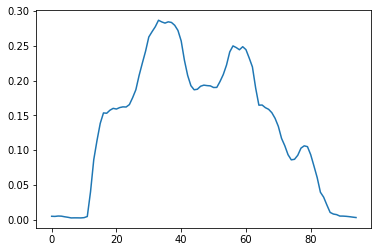

In [ ]:
rms = librosa.feature.rms(s)
plt.plot(rms[0])

# 진폭 (amplitude)의 크기를 plotting 해줌. 즉 소리의 intensity(크기)를 plotting 해줌

# Praat
- 음성 조작, 분석 등을 할 수 있는 packages를 모아놓은 프로그램
- 0427 수업에서 설명
  - spectrogram은 y축이 frequency
  - 어떤 frequency에서 energy가 많은 지가 진하기로 나타나있음 (까말수록 많은 것)